# Kaggle - Predict Future Sales Competition - Data Preparation
In this notebook, we prepare the the Future Sales dataset for modeling

## Setup & Imports

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.preprocessing import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import *
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
from tqdm import tqdm
from multiprocessing import cpu_count

tqdm.pandas()

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load Data
The data set is split into various CSVs files that have to be reconciled together:
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

In [2]:
train_df = pd.read_csv("./data/sales_train.csv")
print(f"train_df cols: {train_df.columns}")
test_df = pd.read_csv("./data/test.csv")
print(f"test_df cols: {test_df.columns}")
items_df = pd.read_csv("./data/items.csv")
print(f"items_df cols: {items_df.columns}")
item_cats_df = pd.read_csv("./data/item_categories.csv")
print(f"items_cats_df cols: {item_cats_df.columns}")
shops_df = pd.read_csv("./data/shops.csv")
print(f"shops_df cols: {shops_df.columns}")

train_df cols: Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
test_df cols: Index(['ID', 'shop_id', 'item_id'], dtype='object')
items_df cols: Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
items_cats_df cols: Index(['item_category_name', 'item_category_id'], dtype='object')
shops_df cols: Index(['shop_name', 'shop_id'], dtype='object')


In [3]:
# merges axillary column from other columns on to the given dataframe df
# returns the with dataframe with merged columns
def merge_axillary_cols(df, shops_df=shops_df, items_df=items_df, 
                        item_cats_df=item_cats_df):
    df = pd.merge(df, shops_df, on="shop_id")
    df = pd.merge(df, items_df, on="item_id")
    df = pd.merge(df, item_cats_df, on="item_category_id")
    
    return df

df = merge_axillary_cols(train_df)
test_df = merge_axillary_cols(test_df)

# Explore Data
Conduct exploratory data analysis on the training set.

Description of each feature derived from Kaggle:
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - **prediction target** number of products sold. You are predicting a _monthly_ amount of this measure @ Nov 2015.
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [4]:
df.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1164841,29.12.2013,11,19,3851,899.0,1.0,"Курск ТЦ ""Пушкинский""",Heavy Rain (Essentials) (с поддержкой PS Move)...,19,Игры - PS3
1276098,28.10.2013,9,43,11813,2699.0,-1.0,"СПб ТК ""Сенная""","За гранью: Две души. Специальное издание [PS3,...",19,Игры - PS3
2038371,16.10.2015,33,39,10200,399.0,1.0,"РостовНаДону ТРК ""Мегацентр Горизонт""","Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",28,Игры PC - Дополнительные издания
1176280,20.02.2013,1,0,17707,734.0,1.0,"!Якутск Орджоникидзе, 56 фран",Праздник спорта (Essentials) (только для PS Mo...,19,Игры - PS3
309561,27.09.2013,8,31,17212,149.0,1.0,"Москва ТЦ ""Семеновский""",ПОЛНОЧЬ В ПАРИЖЕ,40,Кино - DVD


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
date                  object
date_block_num        int64
shop_id               int64
item_id               int64
item_price            float64
item_cnt_day          float64
shop_name             object
item_name             object
item_category_id      int64
item_category_name    object
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


#### Correcting Types
We need to convert the dates into datetime format:

In [6]:
%time  df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")

CPU times: user 7.81 s, sys: 9.86 ms, total: 7.82 s
Wall time: 7.79 s


#### Time Series Ordering
Since the data is time series, we enforce the flow of time by sorting the data:

In [7]:
df = df.sort_values(by="date")

#### Missing Values
Check for missing values:

In [8]:
df.isna().any().any()

False

Display a statistical summary of the training data:

In [9]:
df.describe(include="all")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2935849,2935849,2.935849e+06,2935849
unique,1034,NaN,NaN,NaN,NaN,NaN,60,21807,NaN,84
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,"Москва ТЦ ""Семеновский""",Фирменный пакет майка 1С Интерес белый (34*42)...,NaN,Кино - DVD
freq,9434,NaN,NaN,NaN,NaN,NaN,235636,31340,NaN,564652
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,NaN,NaN,4.000138e+01,NaN
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,NaN,NaN,1.710076e+01,NaN
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,NaN,NaN,0.000000e+00,NaN
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,NaN,NaN,2.800000e+01,NaN


We can observe that:
- the `item_cnt_day` has wrong data, as it should be impossible to sell less than zero items. We can correct this by clipping this data at 0.
- the `item_price` variable might log-normal distirbuted or contain extreme outliers at the higher values. It also have wrong values (min item is priced at -1.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcde2e08e80>,
      dtype=object)

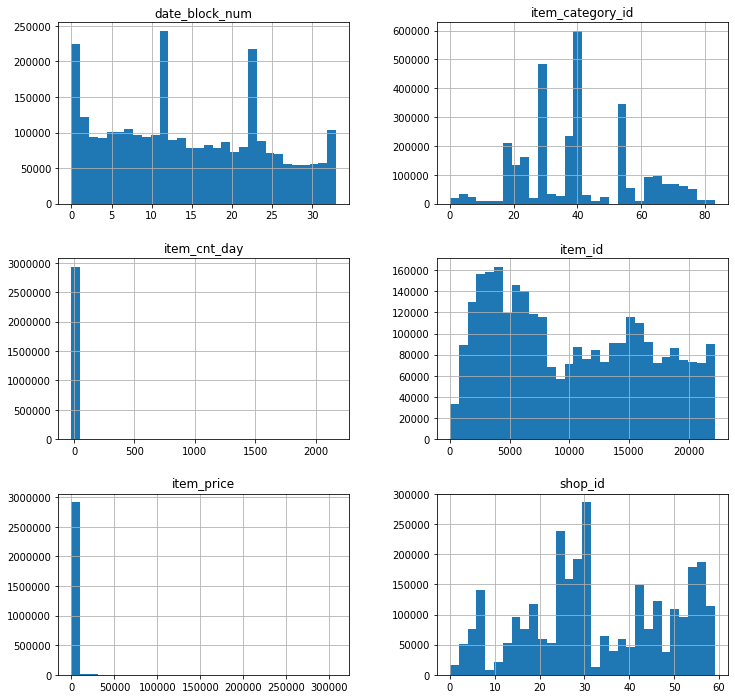

In [10]:
df.hist(figsize=(12, 12), bins=30)

From the above histogram plot we observe:
- `date_block_num` shows sales (by count) spike at intervals, perhaps during holiday shopping season
- `item_id`, `shop_id` and `item_category_id` are categorical variables
- Confirms our hunch that there is an extreme outlier at `item_price`

### Wrong Data: Item Count Day
Item counts per day should not be negative: It does not make logical sense to be able to sell a negative number of items

In [11]:
df["item_cnt_day"] = df["item_cnt_day"].clip(lower=0.0)
df["item_cnt_day"].min()

0.0

### Wrong Data & Extreme Outliers: Item Price
We investigate further by plotting boxplot :

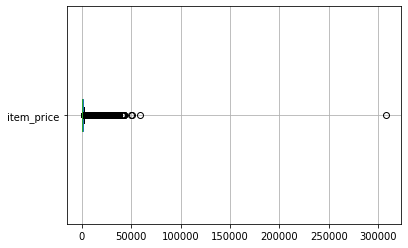

In [12]:
df.boxplot(column="item_price", vert=False)

We clip the data at the 99.95% quantile to remove outliers, and at zero to remove wrong data
(ie you shouldn't be paid to buy something)

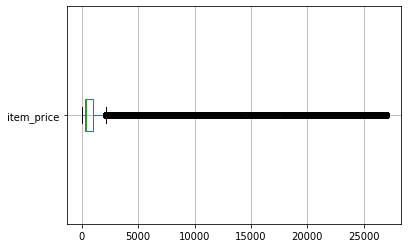

In [13]:
df["item_price"] = df["item_price"].clip(
    lower=0.0,
    upper=df["item_price"].quantile(0.9995))

df.boxplot(column="item_price", vert=False)

### Data Skew: Item Price
We investigate further by plotting the Kernel Density estimate for `item_price`:

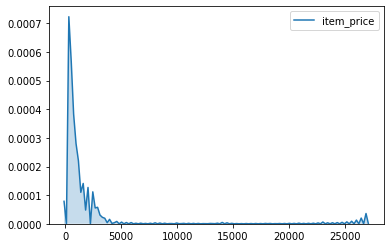

In [14]:
sns.kdeplot(df["item_price"], shade=True)

It appears that our data has a log-normally distributed. To address this we apply a log transform:

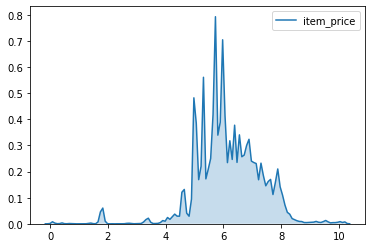

In [15]:
sns.kdeplot(np.log1p(df["item_price"]), shade=True)

In [16]:
df["item_price"] = np.log1p(df["item_price"])

### Different Time Scales
`item_cnt_day` is expressed in the day timescale. However, the problem statement requires us to output the `item_cnt_month` which is basicaly `item_cnt_day` aggregated over the month timescale for each shop. Additional, we are tasked to perform predictions on a per shop basis, hence we also need to aggregate by shop
- Aggregate by examples grouped by `date_block_num`, `item_id` & `shop_id`
    - we use the last `item_price` when aggregating. Since we are predicting on Nov 2015, the last Oct 2015 price are the best estimates.

In [17]:
groups_cols =  ["date_block_num", "item_id", "shop_id"]
df = df.sort_values(by="date_block_num")
item_cnt_month_df = df.groupby(groups_cols).agg(
    item_price=("item_price", "last"),
    item_cnt_month=("item_cnt_day", "sum")).reset_index()

- Merge the aggreated count `item_cnt_month` back into the dataframe:
> We use the default merge method with is inner merge. Since the `item_cnt_month_df` 
> only contains one entry per month, shop, item triple the result `df` also 
> contains one entry per month, shop, item triple.

In [18]:
df = pd.merge(df, item_cnt_month_df, how="inner", on=groups_cols + ["item_price"])

Since the time resolution of the `df` has been reduced monthly interval `item_cnt_day` is no longer a useful feature

In [19]:
df = df.drop(columns="item_cnt_day")

### Missing Columns in Test Data
Some columns in the training set do not exist (with exception of target variable `item_cnt_month` which is our task to predict)

In [20]:
[ col for col in list(df.columns) if col not in list(test_df.columns) ]

['date', 'date_block_num', 'item_price', 'item_cnt_month']

We can manually recreate the `date` and `date_block_num` columns as we know that we are supposed to make predictions for Nov 2015:
> test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

- this would make the `date_block_num` equal to one plus the last date block number
- we use `15/11/2015` (middle of the month) as the date for all test columns

In [21]:
test_date = datetime(2015, 11, 15)
df = df.sort_values(by="date_block_num")
test_date_block_num = df["date_block_num"].max() + 1
test_df["date"] = np.full([len(test_df)], fill_value=test_date)
test_df["date_block_num"] = np.full([len(test_df)], fill_value=test_date_block_num)

Derieve `item_price` from the training dataframe `df`
- compile a price list of each item and shop, median price for each item and the median price for all items

In [22]:
groups_cols = ["item_id", "shop_id"]
df = df.sort_values("date_block_num")
item_price_index = df.groupby(groups_cols).agg(
    item_price=("item_price", "last"))

In [23]:
median_price_index = item_price_index.groupby(["item_id"]).agg(
    median_price=("item_price", "median"))

In [24]:
median_price = item_price_index["item_price"].median()

- use latest pricing for `item_id` and `shop_id` if exists in training data
- use median price for a given item if no price for shop exists
- use median price of all items if no price for item exists


In [25]:
def get_item_price(row, 
                   item_price_index,
                   median_price_index,
                   median_price):
    item_id, shop_id = row
    # check if item price has been recorded before for the store
    if (item_id, shop_id) in item_price_index.index:
        # return the latest price for the item at the store 
        return item_price_index["item_price"][item_id, shop_id]
    # check if item price has been recorded anywhere for the item
    elif item_id in median_price_index.index:
        # return median price for item
        return median_price_index["median_price"][item_id]
    else: # no record of the item price where
        # return median price for all items
        return median_price

In [26]:
%%time
test_df["item_price"] = test_df[["item_id", "shop_id"]].apply(
    get_item_price, axis=1,
    args=(item_price_index,
    median_price_index,
    median_price))

CPU times: user 13.1 s, sys: 7.68 ms, total: 13.1 s
Wall time: 13.1 s


Hence the missing columns problem is resolved: (`item_cnt_month` is prediction target variable, hence is expected to not be inside the test data).

In [27]:
[ col for col in list(df.columns) if col not in list(test_df.columns) ]

['item_cnt_month']

#### Checkpoint Data
Checkpoint the the data corrections we have already completed by commiting them to disk.

In [28]:
if not os.path.exists("build"):
    os.makedirs("build")

df.reset_index().to_feather(os.path.join("build", "train_df.feather"))
test_df.reset_index().to_feather(os.path.join("build", "test_df.feather"))

# Prepare Data
Prepare  data transformation pipeline to prepare the data for modeling

In [29]:
# Load checkpointed data
if os.path.exists("build"):
    df = pd.read_feather(os.path.join("build", "train_df.feather"))
    test_df = pd.read_feather(os.path.join("build", "test_df.feather"))

### Seperate Inputs & Outputs
Seperate the inputs and outputs to the model

In [30]:
sales_features_df = df.drop(columns="item_cnt_month")
sales_month = df["item_cnt_month"]

### Split Test Set
We set aside a test set which we will use later to obtain an unbiases estimate 
of the model's performance

In [31]:
(train_sales_features, test_sales_features,
 train_sales_month, test_sales_month) = train_test_split(sales_features_df, sales_month, test_size=5000)

### Build Data Pipeline
Build a Data Transformation pipeline which will preprocess data for modeling

In [32]:
# pipeline for numeric fatures
num_features = ["item_price"]
num_pipeline = Pipeline([
    ("scaler", StandardScaler()),
])

# pipeline for categorical features
cat_features = ["shop_id", "item_id", "item_category_id"]
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder()),
])

# pipeline for text features
text_features = ["shop_name", "item_name"]
# create a text pipeline for each text feature
text_pipelines = [ 
    (f"text_pipeline_{feat}",
    Pipeline([
        ("vectorizer", TfidfVectorizer()),
    ]), feat) for feat in text_features ]

input_pipeline = ColumnTransformer(
[
    ("num_pipeline", num_pipeline, num_features),
    ("cat_pipeline", cat_pipeline, cat_features),
] + text_pipelines, n_jobs=cpu_count() - 2)

In [33]:
%%time
input_pipeline.fit(train_sales_features)
joblib.dump(input_pipeline, "input_pipeline.joblib", compress=3)

CPU times: user 2.36 s, sys: 1.44 s, total: 3.8 s
Wall time: 28.1 s


Use the input pipeline to prepare the data for machine learning

In [34]:
%%time
train_sales_features_prepared = input_pipeline.transform(train_sales_features)
test_sales_features_prepared = input_pipeline.transform(test_sales_features)

CPU times: user 2.42 s, sys: 1.04 s, total: 3.46 s
Wall time: 28.6 s


# Commit Data
Commit the prepared data to disk

In [35]:
%%time
sparse.save_npz("build/train_sales_features.npz", train_sales_features_prepared)
sparse.save_npz("build/test_sales_features.npz", test_sales_features_prepared)
np.savez_compressed("build/sales_month.npz", 
                    train=train_sales_month,
                    test=test_sales_month)

CPU times: user 16.2 s, sys: 104 ms, total: 16.3 s
Wall time: 16.3 s
